In [1]:
import numpy as np
import scipy as sy
from scipy import special

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
heatmapcolour = cm.coolwarm
heatmapcolour.set_bad('w',1.)
plt.rcParams.update({'font.size': 20})
mp.rc('xtick', labelsize=20)     
mp.rc('ytick', labelsize=20)
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator, MonthLocator, DayLocator

'''
import uncertainties
from uncertainties import ufloat
from uncertainties import umath
from uncertainties.umath import *  # sin(), etc.
from uncertainties import unumpy  # Array manipulation
from uncertainties import ufloat_fromstr
'''

import sympy as sm
from sympy.solvers.ode import dsolve
sm.init_printing()

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import requests
from os import getcwd

In [2]:
def CovidCountryData(names, marker):
    formater = '%Y-%m-%d'
    indexor = CountryCovidData['Country'].where(
        CountryCovidData['Country'] == names)
    indexor = indexor.dropna()

    Dates = CountryCovidData['Date'][indexor.index]
    Confirm = CountryCovidData['Confirmed'][indexor.index]
    Recov = CountryCovidData['Recovered'][indexor.index]
    Dead = CountryCovidData['Deaths'][indexor.index]
    namesData = {'Date': Dates, 'Confirmed': Confirm,
                 'Recovered': Recov, 'Deaths': Dead}
    Datanames = pd.DataFrame(data=namesData)
    Datanames['Datetime'] = pd.to_datetime(Datanames['Date'], format=formater)
    Final = pd.DataFrame(data=Datanames)
    Final = Final.set_index(pd.DatetimeIndex(Final['Datetime']))
    Final = Final.drop(['Datetime'], axis=1)

    marker_index = Datanames['Confirmed'].where(
        Datanames['Confirmed'] > marker)
    marker_index = marker_index.dropna()

    Dates = Datanames['Date'][marker_index.index]
    Confirm = Datanames['Confirmed'][marker_index.index]
    Recov = Datanames['Recovered'][marker_index.index]
    Dead = Datanames['Deaths'][marker_index.index]
    namesData = {'Date': Dates, 'Confirmed': Confirm,
                 'Recovered': Recov, 'Deaths': Dead}
    Datanames = pd.DataFrame(data=namesData)
    Datanames['Datetime'] = pd.to_datetime(Datanames['Date'], format=formater)
    Final_Marker = pd.DataFrame(data=Datanames)
    Final_Marker = Final_Marker.set_index(
        pd.DatetimeIndex(Final_Marker['Datetime']))
    Final_Marker = Final_Marker.drop(['Datetime'], axis=1)

    _len = {'Confirmed': np.linspace(0, Final_Marker['Confirmed'].size, 
        Final_Marker['Confirmed'].size), 'Recovered': np.linspace(
        0, Final_Marker['Recovered'].size, Final_Marker['Recovered'].size),
        'Deaths': np.linspace(0, Final_Marker['Deaths'].size,
        Final_Marker['Deaths'].size)}
    marker_len = pd.DataFrame(data=_len)
    return Final, Final_Marker, marker_len

In [3]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

In [4]:
### Sources Data ###
url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/"



### My Data ###
#url = "https://raw.githubusercontent.com/Aestria/covid-19/master/data/"

In [9]:
CountryCovidData = pd.read_csv(url + 'countries-aggregated.csv')#, error_bad_lines=False)
WorldCovidData = pd.read_csv(url + 'worldwide-aggregated.csv')#, error_bad_lines=False)

### Want to create Plots for:

Americas

Europe

Asia

SE Islands


In [10]:
# For saving the graphs. 
#   'True' for saving
#   'False' for not saving

save_on = False

In [11]:
### North America ###
Canada, Canada_1000, Canada_len = CovidCountryData('Canada', 1000)
USA, USA_1000, USA_len = CovidCountryData('US', 1000)
Mexico, Mexico_1000, Mexico_len = CovidCountryData('Mexico', 1000)

### South America ###
Brazil, Brazil_1000, Brazil_len = CovidCountryData('Brazil', 1000)
Chile, Chile_1000, Chile_len = CovidCountryData('Chile', 1000)
Argentina, Argentina_1000, Argentina_len = CovidCountryData('Argentina', 1000)
Colombia, Colombia_1000, Colombia_len = CovidCountryData('Colombia', 1000)
Venezuela, Venezuela_1000, Venezuela_len = CovidCountryData('Venezuela', 1000)

### Europe ###
Spain, Spain_1000, Spain_len = CovidCountryData('Spain', 1000)
Italy, Italy_1000, Italy_len = CovidCountryData('Italy', 1000)
Austria, Austria_1000, Austria_len = CovidCountryData('Austria', 1000)
Belgium, Belgium_1000, Belgium_len = CovidCountryData('Belgium', 1000)
Denmark, Denmark_1000, Denmark_len = CovidCountryData('Denmark', 1000)
France, France_1000, France_len = CovidCountryData('France', 1000)
Germany, Germany_1000, Germany_len = CovidCountryData('Germany', 1000)
Netherlands, Netherlands_1000, Netherlands_len = CovidCountryData('Netherlands', 1000)
Norway, Norway_1000, Norway_len = CovidCountryData('Norway', 1000)
Portugal, Portugal_1000, Portugal_len = CovidCountryData('Portugal', 1000)
Romania, Romania_1000, Romania_len = CovidCountryData('Romania', 1000)
Russia, Russia_1000, Russia_len = CovidCountryData('Russia', 1000)
Sweden, Sweden_1000, Sweden_len = CovidCountryData('Sweden', 1000)
Switzerland, Switzerland_1000, Switzerland_len = CovidCountryData('Switzerland', 1000)
Turkey, Turkey_1000, Turkey_len = CovidCountryData('Turkey', 1000)
Ukraine, Ukraine_1000, Ukraine_len = CovidCountryData('Ukraine', 1000)
UnitedKingdom, UnitedKingdom_1000, UnitedKingdom_len = CovidCountryData('United Kingdom', 1000)
Poland, Poland_1000, Poland_len = CovidCountryData('Poland', 1000)

### Asia ###
China, China_1000, China_len = CovidCountryData('China', 1000)
SKorea, SKorea_1000, SKorea_len = CovidCountryData('Korea, South', 1000)

### SE Asia + Aussy and NZ ###
Philippines, Philippines_1000, Philippines_len = CovidCountryData('Philippines', 1000)
Indonesia, Indonesia_1000, Indonesia_len = CovidCountryData('Indonesia', 1000)
Australia, Australia_1000, Australia_len = CovidCountryData('Australia', 1000)
NewZealand, NewZealand_1000, NewZealand_len = CovidCountryData('New Zealand', 1000)


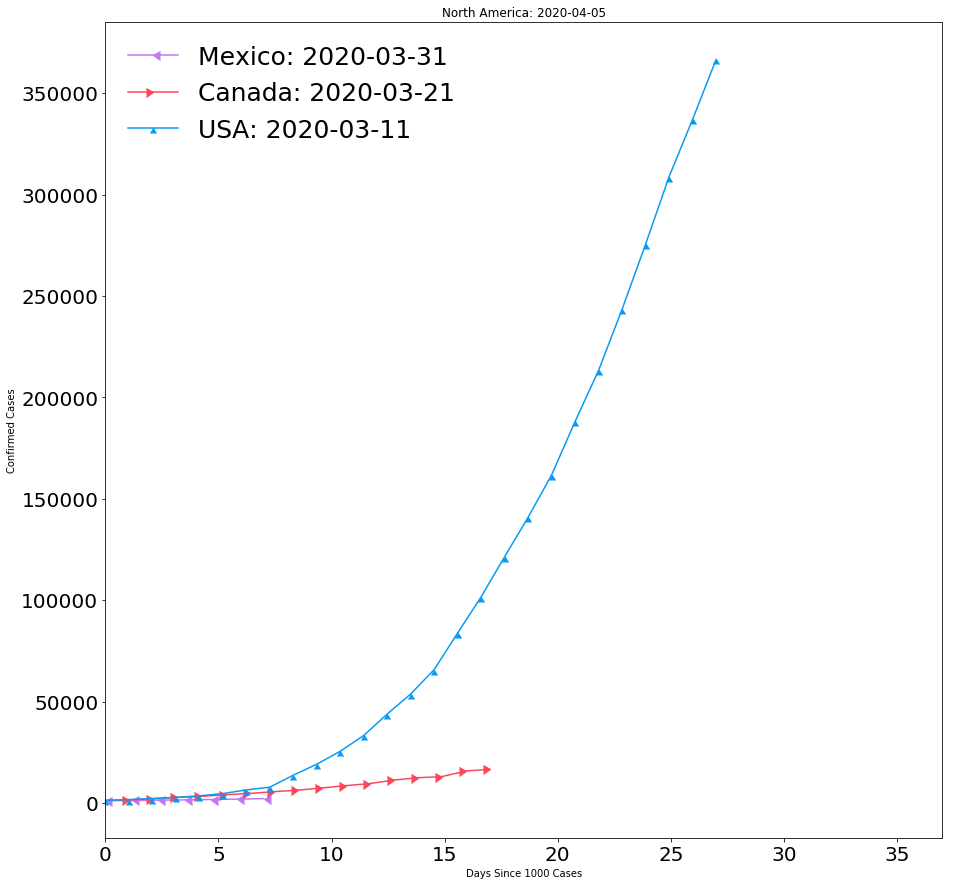

In [12]:
sizes = 6

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15, 15))

ax1.plot(Mexico_len['Confirmed'], Mexico_1000['Confirmed'], color = '#bf77f6', marker = 4, markersize = 1.5*sizes, label='Mexico: '+ Mexico_1000['Date'][0])
ax1.plot(Canada_len['Confirmed'], Canada_1000['Confirmed'], color = '#fd4659', marker = 5, markersize = 1.5*sizes, label='Canada: '+ Canada_1000['Date'][0])
ax1.plot(USA_len['Confirmed'], USA_1000['Confirmed'], color = '#069af3', marker = 6, markersize = sizes, label='USA: '+ USA_1000['Date'][0])

ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)
ax1.set_xlim(0,37)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('North America: 2020-04-05')

if save_on:
    f1.savefig('NorthAmerica.png')
    f1.savefig('NorthAmerica.pdf')
    plt.close()
else:
    plt.show()

In [ ]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

sizes = 6

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15, 15))

ax1.plot(Brazil_len['Confirmed'], Brazil_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, label='Brazil: '+ Brazil_1000['Date'][0])
ax1.plot(Chile_len['Confirmed'], Chile_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, label='Chile: '+ Chile_1000['Date'][0])
ax1.plot(Argentina_len['Confirmed'], Argentina_1000['Confirmed'], color = '#5f1b6b', marker = 6, markersize = sizes, label='Argentina: '+ Argentina_1000['Date'][0])
ax1.plot(Colombia_len['Confirmed'], Colombia_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, label='Colombia: '+ Colombia_1000['Date'][0])

ax1.legend(ncol=1, frameon=False, loc=4, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('South America: 2020-04-05')

ax1.set_xlim(0,37)

if save_on:
    f1.savefig('SouthAmerica.png')
    f1.savefig('SouthAmerica.pdf')
    plt.close()
else:
    plt.show()

In [ ]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

sizes = 6

f1, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(15, 45))

ax1.plot(Spain_len['Confirmed'], Spain_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, label='Spain: '+ Spain_1000['Date'][0])
ax1.plot(Italy_len['Confirmed'], Italy_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, label='Italy: '+ Italy_1000['Date'][0])
ax1.plot(Germany_len['Confirmed'], Germany_1000['Confirmed'], color = '#05480d', marker = 4, markersize = sizes, label='Germany: '+ Germany_1000['Date'][0])
ax1.plot(France_len['Confirmed'], France_1000['Confirmed'], color = '#dc4d01', marker = 7, markersize = sizes, label='France: '+ France_1000['Date'][0])
ax1.plot(UnitedKingdom_len['Confirmed'], UnitedKingdom_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, label='UK: '+ UnitedKingdom_1000['Date'][0])

ax2.plot(Turkey_len['Confirmed'], Turkey_1000['Confirmed'], color = '#aa2704', marker = 6, markersize = sizes, label='Turkey: '+ Turkey_1000['Date'][0])
ax2.plot(Belgium_len['Confirmed'], Belgium_1000['Confirmed'], color = '#155084', marker = 7, markersize = sizes, label='Belgium: '+ Belgium_1000['Date'][0])
ax2.plot(Netherlands_len['Confirmed'], Netherlands_1000['Confirmed'], color = '#05480d', marker = 5, markersize = sizes, label='Netherlands: '+ Netherlands_1000['Date'][0])
ax2.plot(Austria_len['Confirmed'], Austria_1000['Confirmed'], color = '#dc4d01', marker = 6, markersize = sizes, label='Austria: '+ Austria_1000['Date'][0])
ax2.plot(Portugal_len['Confirmed'], Portugal_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, label='Portugal: '+ Portugal_1000['Date'][0])
ax2.plot(Switzerland_len['Confirmed'], Switzerland_1000['Confirmed'], color = '#653700', marker = 5, markersize = sizes, label='Switzerland: '+ Switzerland_1000['Date'][0])

ax3.plot(Norway_len['Confirmed'], Norway_1000['Confirmed'], color = '#aa2704', marker = 6, markersize = sizes, label='Norway: '+ Norway_1000['Date'][0])
ax3.plot(Romania_len['Confirmed'], Romania_1000['Confirmed'], color = '#155084', marker = 7, markersize = sizes, label='Romania: '+ Romania_1000['Date'][0])
ax3.plot(Russia_len['Confirmed'], Russia_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, label='Russia: '+ Russia_1000['Date'][0])
ax3.plot(Sweden_len['Confirmed'], Sweden_1000['Confirmed'], color = '#dc4d01', marker = 4, markersize = sizes, label='Sweden: '+ Sweden_1000['Date'][0])
ax3.plot(Denmark_len['Confirmed'], Denmark_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, label='Denmark: '+ Denmark_1000['Date'][0])
ax3.plot(Ukraine_len['Confirmed'], Ukraine_1000['Confirmed'], color = '#000000', marker = 7, markersize = sizes, label='Ukraine: '+ Ukraine_1000['Date'][0])
ax3.plot(Poland_len['Confirmed'], Poland_1000['Confirmed'], color = '#653700', marker = 7, markersize = sizes, label='Poland: '+ Poland_1000['Date'][0])

ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax2.legend(ncol=1, frameon=False, loc=4, scatterpoints=1, markerscale=1, fontsize=20)
ax3.legend(ncol=1, frameon=False, loc=4, scatterpoints=1, markerscale=1, fontsize=20)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Europe: 2020-04-05')

ax2.set_ylabel('Confirmed Cases')
ax2.set_xlabel('Days Since 1000 Cases')
ax2.set_title('Europe: 2020-04-05')

ax3.set_ylabel('Confirmed Cases')
ax3.set_xlabel('Days Since 1000 Cases')
ax3.set_title('Europe: 2020-04-05')

if save_on:
    f1.savefig('Europe.png')
    f1.savefig('Europe.pdf')
    plt.close()
else:
    plt.show()

In [ ]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

sizes = 6

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15, 15))

ax1.plot(Philippines_len['Confirmed'], Philippines_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, label='Philippines: '+ Philippines_1000['Date'][0])
ax1.plot(Indonesia_len['Confirmed'], Indonesia_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, label='Indonesia: '+ Indonesia_1000['Date'][0])
ax1.plot(Australia_len['Confirmed'], Australia_1000['Confirmed'], color = '#5f1b6b', marker = 6, markersize = sizes, label='Australia: '+ Australia_1000['Date'][0])
ax1.plot(NewZealand_len['Confirmed'], NewZealand_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, label='NewZealand: '+ NewZealand_1000['Date'][0])

ax1.legend(ncol=1, frameon=False, loc=4, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('South Eastern Islands: 2020-04-05')

ax1.set_xlim(0,37)

if save_on:
    f1.savefig('SEIslands.png')
    f1.savefig('SEIslands.pdf')
    plt.close()
else:
    plt.show()

In [ ]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

sizes = 6

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15, 15))

ax1.plot(Canada_len['Confirmed'], Canada_1000['Confirmed'], color = '#aa2704', marker = 5, markersize = 1.5*sizes, label='Canada: '+ Canada_1000['Date'][0])
ax1.plot(Brazil_len['Confirmed'], Brazil_1000['Confirmed'], color = '#155084', marker = 4, markersize = sizes, label='Brazil: '+ Brazil_1000['Date'][0])
ax1.plot(Belgium_len['Confirmed'], Belgium_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, label='Belgium: '+ Belgium_1000['Date'][0])
ax1.plot(Netherlands_len['Confirmed'], Netherlands_1000['Confirmed'], color = '#dc4d01', marker = 5, markersize = sizes, label='Netherlands: '+ Netherlands_1000['Date'][0])
ax1.plot(Portugal_len['Confirmed'], Portugal_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, label='Portugal: '+ Portugal_1000['Date'][0])
ax1.plot(Switzerland_len['Confirmed'], Switzerland_1000['Confirmed'], color = '#653700', marker = 5, markersize = sizes, label='Switzerland: '+ Switzerland_1000['Date'][0])
ax1.plot(Austria_len['Confirmed'], Austria_1000['Confirmed'], color = '#000000', marker = 6, markersize = sizes, label='Austria: '+ Austria_1000['Date'][0])


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Countries with Around 15000 Cases: 2020-04-05')

if save_on:
    f1.savefig('15000Range.png')
    f1.savefig('15000Range.pdf')
    plt.close()
else:
    plt.show()